# Email Spam Detection: Tfidf, Deep Learning & Transformers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,f1_score
from sklearn.metrics import roc_auc_score, auc
from sklearn.pipeline import Pipeline
from mlxtend.plotting import plot_confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
import string

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Create a list of stopwords
stop_words = list(set(stopwords.words('english')))

# Create a list of punctuation
punc = list(string.punctuation)

**Load dataset**

In [4]:
def load_dataset(dataset_path):
    df = pd.read_csv(dataset_path,usecols=['v1','v2'],encoding='ISO-8859-1')
    print("Number of records:",len(df))
    print("\nColumn Types:\n",df.dtypes)
    return df

In [5]:
df = load_dataset(r'/kaggle/input/email-spam-detection-dataset-classification/spam.csv')
df.head()

Number of records: 5572

Column Types:
 v1    object
v2    object
dtype: object


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Rename columns

df.rename(columns={'v1':'label','v2':'text'},inplace=True)
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# label count
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

**Text Preprocessing**

In [8]:
def preprocess_text(text):
    # convert to lowercase
    text = str(text).lower()
    # remove special characters
    text = re.sub(r'[^\w ]+','',text)
    # remove non-ascii
    text = ''.join(word for word in text if ord(word) < 128)
    # remove punctuations
    text = text.translate(str.maketrans('','',string.punctuation))
    # remove digits
    text = re.sub(r'[\d]+','',text)
    # remove single letters
    text = ' '.join(word for word in text.split() if len(word)>1)
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # remove extra spaces
    text = ' '.join(text.split())
    return text

In [9]:
# Apply preprocessing

df_final = df.copy()
df_final['text'] = df_final.loc[:,'text'].apply(lambda x:preprocess_text(x))

# Change label to numeric
df_final['label'] = df_final.loc[:,'label'].map({'ham':0,'spam':1})
df_final.head()

,label,text
0,0,go jurong point crazy available bugis great wo...
1,0,ok lar joking wif oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,dun say early hor already say
4,0,nah dont think goes usf lives around though


**Data Visualization**

In [10]:
def visualize(label):
    words = ''
    for txt in df_final[df_final['label'] == label]['text']:
        words = words + txt + ' '
        
    wordcloud = WordCloud(width=500,height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

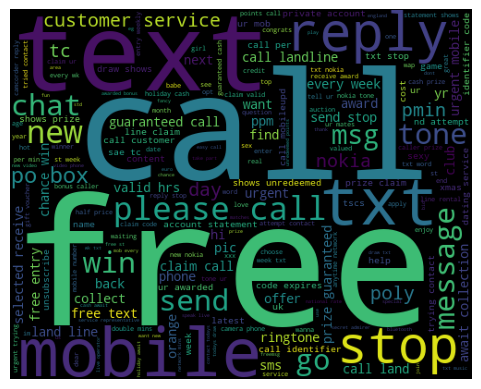

In [11]:
# Visualize Spam text

visualize(1)

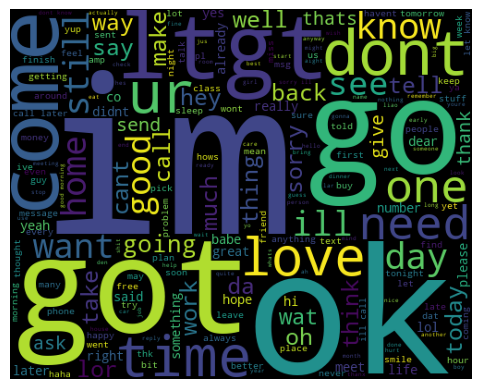

In [12]:
# Visualize Ham

visualize(0)

**Train-Test Split**

In [13]:
# Split the dataset into train and test

X = df_final['text']
y = df_final['label']

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,shuffle=True,stratify=y,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4457,), (1115,), (4457,), (1115,))

In [14]:
from transformers import pipeline
from datasets import load_dataset

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

**Convert dataset into format for transformers**

In [15]:
# Save to file

df_copy = df.copy()
df_copy['label'] = df_copy.loc[:,'label'].map({"ham":0,"spam":1})

df_copy.to_csv('df.csv',index=None)

# Convert format
raw_dataset = load_dataset('csv',data_files='df.csv')
raw_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-e17cc0202ef5edd9/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 5572
    })
})

**Split into train and test**

In [16]:
split = raw_dataset['train'].train_test_split(train_size=0.7,seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 3900
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1672
    })
})

**Define tokenizer**

In [17]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [18]:
# Function for tokenizing

def tokenize_fn(batch):
    return tokenizer(str(batch['text']),truncation=True)

**Tokenize dataset**

In [19]:
tokenized_dataset = split.map(tokenize_fn)
tokenized_dataset

  0%|          | 0/3900 [00:00<?, ?ex/s]

  0%|          | 0/1672 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 3900
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1672
    })
})

**Dynamic Padding**

In [20]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

**Evaluate**

In [21]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00


In [22]:
# Function for evaluation

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = np.mean(predictions==labels)
    f1 = f1_score(labels,predictions,average='macro')
    return({'accuracy':acc,'f1':f1})

**Training**

In [23]:
id2label = {0: "Ham", 1: "Spam"}
label2id = {"Ham": 0, "Spam": 1}

In [24]:
# Model

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.we

In [26]:
import os
from torch.optim import AdamW

# Disable W&B logging
os.environ["WANDB_DISABLED"] = "true"

# Training arguments
training_args = TrainingArguments(
    output_dir='email_spam_detection',
    learning_rate=2e-5,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=2,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=8
)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)

# Trainer with custom optimizer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None)  # Pass optimizer, leave scheduler as None
)

# Train the model
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.025866,0.992823,0.985604
2,No log,0.025815,0.994019,0.987880


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=390, training_loss=0.05999698149852264, metrics={'train_runtime': 62.2259, 'train_samples_per_second': 125.35, 'train_steps_per_second': 6.267, 'total_flos': 134511329221200.0, 'train_loss': 0.05999698149852264, 'epoch': 2.0})

**Predictions on test set**

In [27]:
savedmodel = pipeline('text-classification',
                      model='/kaggle/working/email_spam_detection/checkpoint-390',
                      device=0)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [28]:
split['test']

Dataset({
    features: ['label', 'text'],
    num_rows: 1672
})

In [29]:
test_prediction = savedmodel(split['test']['text'])
test_prediction[:5]

[{'label': 'Ham', 'score': 0.9985221028327942},
 {'label': 'Ham', 'score': 0.9983781576156616},
 {'label': 'Ham', 'score': 0.9984924793243408},
 {'label': 'Ham', 'score': 0.9980156421661377},
 {'label': 'Ham', 'score': 0.9975093603134155}]

In [30]:
# Get labels

pred_labels = [label2id[d['label']] for d in test_prediction]
pred_labels[:5]

[0, 0, 0, 0, 0]

In [31]:
print('Accuracy:',accuracy_score(split['test']['label'],pred_labels))

Accuracy: 0.9940191387559809


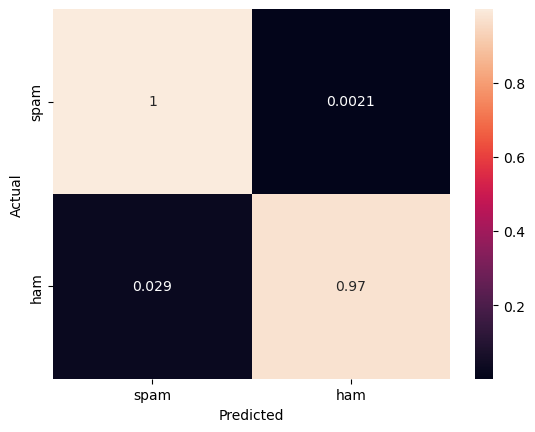

In [32]:
# Confusion matrix
cm = confusion_matrix(split['test']['label'],pred_labels,normalize='true')

def plot_cm(cm):
    classes = ['spam','ham']
    df_cm = pd.DataFrame(cm,index=classes,columns=classes)
    ax = sns.heatmap(df_cm,annot=True,fmt='.2g')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plot_cm(cm)